In [46]:
from pathlib import Path
from collections import defaultdict
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from deep_ei import topology_of, ei_of_layer, sensitivity_of_layer

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using device: {device}")

Using device: cuda


In [12]:
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))
                    
def rainbowMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("rainbow")
    return colormap(1.0 * pos / size)

def magmaMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("magma")
    return colormap(0.7 * pos / size + 0.2)

def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

In [3]:
initializers = {
    'kaiming': None, # (default)
    'xavier_uniform': nn.init.xavier_uniform_,
    'xavier_normal': nn.init.xavier_normal_,
    'paper': nn.init.uniform_
}

def weight_initializer(name):
    def init_weights(m):
        if name == 'kaiming':
            return
        if name == 'paper':
            if isinstance(m, nn.Linear):
                boundary = 1 / np.sqrt(m.in_features)
                nn.init.uniform_(m.weight, a=-boundary, b=boundary)
        elif isinstance(m, nn.Linear):
            initializers[name](m.weight)
    return init_weights

In [37]:
bins = [8, 16, 32, 64, 128, 256, 512]

# Danger Zone

In [8]:
WIDTH = 30
samples = [10000, 20000, 50000, 100000, 500000, 1000000, 10000000]

In [9]:
layer = nn.Linear(WIDTH, WIDTH, bias=False).to(device)
top = topology_of(layer, input=torch.zeros((1, WIDTH)).to(device))

In [10]:
eis = defaultdict(list)

In [11]:
for b in bins:
    for size in samples:
        ei = ei_of_layer(layer, top,
                        samples=size,
                        in_range=(0, 1),
                        in_bins=b,
                        out_range=(0, 1),
                        out_bins=b,
                        activation=nn.Sigmoid(),
                        device=device)
        print(f"samples {size} done")
        eis[b].append(ei)
    print(f"Done with {b} bins")

samples 10000 done
samples 20000 done
samples 50000 done
samples 100000 done
samples 500000 done
samples 1000000 done
samples 10000000 done
Done with 8 bins
samples 10000 done
samples 20000 done
samples 50000 done
samples 100000 done
samples 500000 done
samples 1000000 done
samples 10000000 done
Done with 16 bins
samples 10000 done
samples 20000 done
samples 50000 done
samples 100000 done
samples 500000 done
samples 1000000 done
samples 10000000 done
Done with 32 bins
samples 10000 done
samples 20000 done
samples 50000 done
samples 100000 done
samples 500000 done
samples 1000000 done
samples 10000000 done
Done with 64 bins
samples 10000 done
samples 20000 done
samples 50000 done
samples 100000 done
samples 500000 done
samples 1000000 done
samples 10000000 done
Done with 128 bins
samples 10000 done
samples 20000 done
samples 50000 done
samples 100000 done
samples 500000 done
samples 1000000 done
samples 10000000 done
Done with 256 bins
samples 10000 done
samples 20000 done
samples 50000

In [24]:
samples.append(30000000)

In [25]:
for b in bins:
    ei = ei_of_layer(layer, top,
                samples=30000000,
                in_range=(0, 1),
                in_bins=b,
                out_range=(0, 1),
                out_bins=b,
                activation=nn.Sigmoid(),
                device=device)
    eis[b].append(ei)
    print(f"Done with {b} bins")

Done with 8 bins
Done with 16 bins
Done with 32 bins
Done with 64 bins
Done with 128 bins
Done with 256 bins
Done with 512 bins


In [26]:
samples

[10000, 20000, 50000, 100000, 500000, 1000000, 10000000, 30000000]

In [36]:
data = {
    'sample_sizes': samples,
    'eis': eis
}

with open("saved_data/id-convergence.pkl", 'wb') as f:
    pickle.dump(data, f)

In [93]:
samples.insert(6, 3200000)
samples.append(100000000)

In [94]:
for b in bins:
    ei = ei_of_layer(layer, top,
                samples=3200000,
                in_range=(0, 1),
                in_bins=b,
                out_range=(0, 1),
                out_bins=b,
                activation=nn.Sigmoid(),
                device=device)
    eis[b].insert(6, ei)
    print(f"Done with {b} bins")

Done with 8 bins
Done with 16 bins
Done with 32 bins
Done with 64 bins
Done with 128 bins
Done with 256 bins
Done with 512 bins


In [95]:
for b in bins:
    ei = ei_of_layer(layer, top,
                samples=100000000,
                in_range=(0, 1),
                in_bins=b,
                out_range=(0, 1),
                out_bins=b,
                activation=nn.Sigmoid(),
                device=device)
    eis[b].append(ei)
    print(f"Done with {b} bins")

Done with 8 bins
Done with 16 bins
Done with 32 bins
Done with 64 bins
Done with 128 bins
Done with 256 bins
Done with 512 bins


In [100]:
samples.remove(3200000)

In [106]:
data = {
    'sample_sizes': samples,
    'eis': eis
}

with open("saved_data/id-convergence.pkl", 'wb') as f:
    pickle.dump(data, f)

# Done with Danger Zone

In [107]:
# Load data:
with open("saved_data/id-convergence.pkl", 'rb') as f:
    data = pickle.load(f)

samples = data['sample_sizes']
eis = data['eis']

In [119]:
len(samples)

10

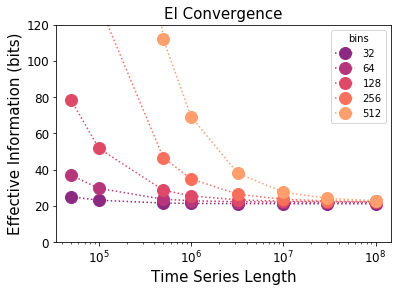

In [143]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

for b in bins[2:]:
    plt.plot(samples[2:], eis[b][2:], color=magmaMap(bins, b), ls=':', marker='o', markersize=12, label=str(b))
# for b in bins[2:]:
#     plt.scatter(samples[4:], eis[b][4:], color=magmaMap(bins, b), label=str(b), s=120)

ax.set_title("EI Convergence", fontsize=15)
ax.set_xlabel('Time Series Length', fontsize=15)
ax.set_ylabel('Effective Information (bits)', fontsize=15)
plt.xscale('log')
plt.ylim(0, 120)
# plt.xlim(400000, 120000000)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(loc='upper right', title="bins")
plt.savefig("conv-scatter-plot-with-lines.png", dpi=300, bbox_inches='tight')